## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_IT_AT import *
from scripts.xgb_helpers import *
from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.ItalyAustriaConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    # "aspect_sgi",  # SGI
    # "slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    # "millan_v",  # OGGM
]

## Read GL data:

In [4]:
data_wgms = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/DOI-WGMS-FoG-2025-02b/csv/IT_AT_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 24
Number of winter, summer and annual samples: 5086
Number of annual samples: 2872
Number of winter samples: 1548
Number of summer samples: 666


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'RGIId', 'YEAR',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

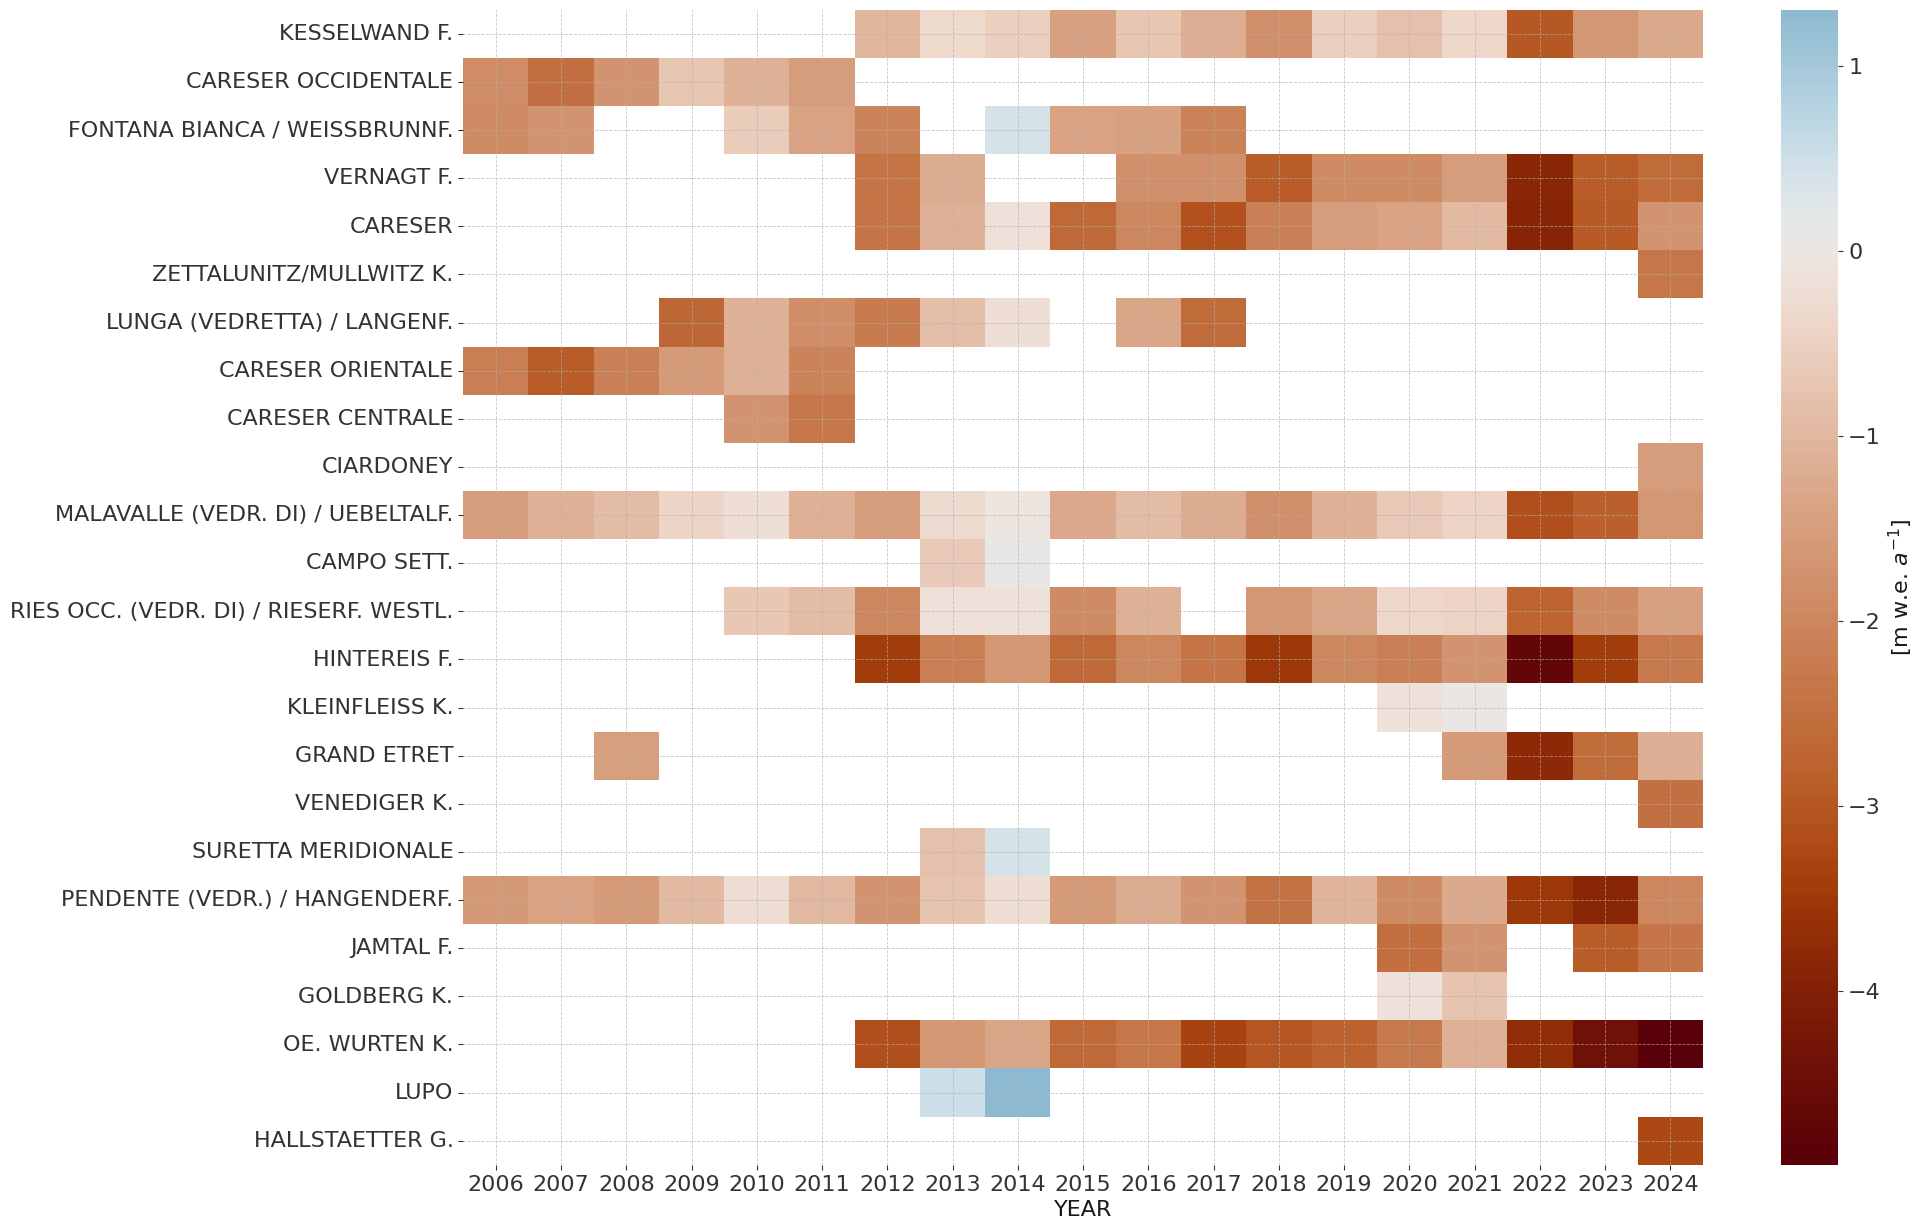

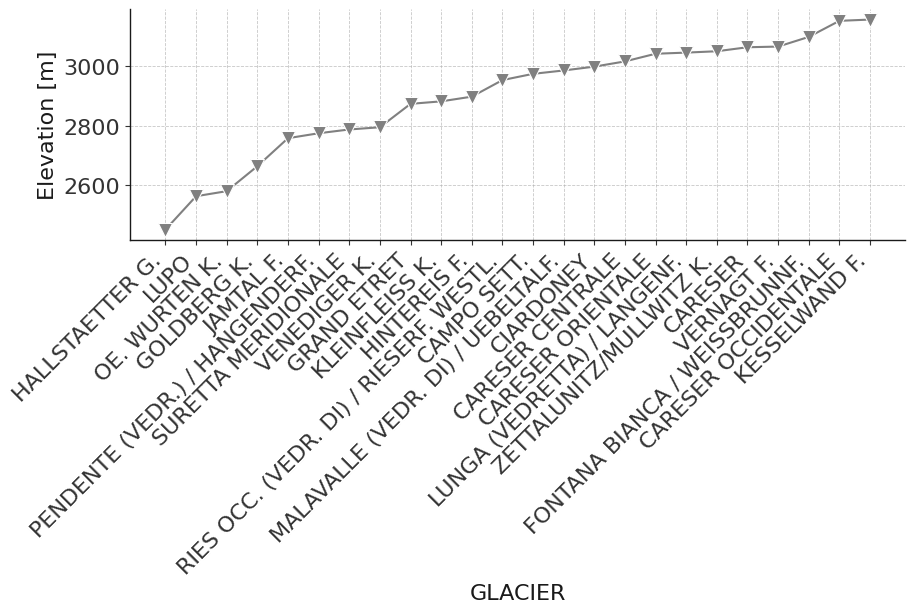

In [5]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier

mean_mb_per_glacier = data_wgms.copy()
mean_mb_per_glacier['YEAR'] = mean_mb_per_glacier['TO_DATE'].astype(str).str[:4].astype(int)

mean_mb_per_glacier = mean_mb_per_glacier.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] == 'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_wgms.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 3))  # Made figure slightly taller for labels
ax = plt.subplot(1, 1, 1)
sorted_elevations = gl_per_el.sort_values(ascending=True)

sns.lineplot(sorted_elevations,
             ax=ax,
             color='gray',
             marker='v')

# Add glacier names as x-tick labels
ax.set_xticks(range(len(sorted_elevations)))
ax.set_xticklabels(sorted_elevations.index, rotation=45, ha='right')
ax.set_ylabel('Elevation [m]')
plt.tight_layout()

In [6]:
data_wgms_test = data_wgms.copy()

print(data_wgms_test.shape)

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_scratch.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_scratch.nc'
    #'radiation_save_path': path_pcsr + 'zarr/'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

2025-04-30 08:42:32,184 - INFO - Number of annual and seasonal samples: 5086
2025-04-30 08:42:32,186 - INFO - Running on 24 glaciers:
['GOLDBERG K.' 'HALLSTAETTER G.' 'HINTEREIS F.' 'JAMTAL F.'
 'KESSELWAND F.' 'KLEINFLEISS K.' 'OE. WURTEN K.' 'VENEDIGER K.'
 'VERNAGT F.' 'ZETTALUNITZ/MULLWITZ K.' 'CAMPO SETT.' 'CARESER'
 'CARESER CENTRALE' 'CARESER OCCIDENTALE' 'CARESER ORIENTALE' 'CIARDONEY'
 'FONTANA BIANCA / WEISSBRUNNF.' 'GRAND ETRET'
 'LUNGA (VEDRETTA) / LANGENF.' 'LUPO' 'MALAVALLE (VEDR. DI) / UEBELTALF.'
 'PENDENTE (VEDR.) / HANGENDERF.' 'RIES OCC. (VEDR. DI) / RIESERF. WESTL.'
 'SURETTA MERIDIONALE']


2025-04-30 08:42:32,242 - INFO - Number of winter and annual samples: 5086
2025-04-30 08:42:32,244 - INFO - Number of annual samples: 2872
2025-04-30 08:42:32,246 - INFO - Number of winter samples: 1548
2025-04-30 08:42:32,246 - INFO - Adding climate features...


(5086, 16)


2025-04-30 08:42:38,799 - INFO - Converting to monthly resolution...
2025-04-30 08:42:51,187 - INFO - Number of monthly rows: 51684
2025-04-30 08:42:51,188 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'hugonnet_dhdt', 'consensus_ice_thickness', 't2m', 'tp', 'slhf', 'sshf',
       'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-04-30 08:42:52,280 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/DOI-WGMS-FoG-2025-02b/csv/IT_AT_wgms_dataset_monthly_full.csv


In [ ]:
display(data_monthly.head(2))



,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,consensus_ice_thickness,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2020,12.965073,47.041127,0.276,2005.391746,694.608254,2700.0,RGI60-11.00289,AT_GOLDBERG K._2020_43346,0,...,48.199932,4.488969,0.003263,-2.294197e+06,-1.238352e+06,9.166772e+06,0.229960,-3.531357e+06,0.265244,0.430310
1,2020,12.965073,47.041127,0.276,2005.391746,694.608254,2700.0,RGI60-11.00289,AT_GOLDBERG K._2020_43346,0,...,48.199932,-2.252254,0.011190,-3.506452e+05,-2.978029e+05,5.373250e+06,0.610373,-2.029104e+06,0.098150,0.601325


#### Feature Correlation

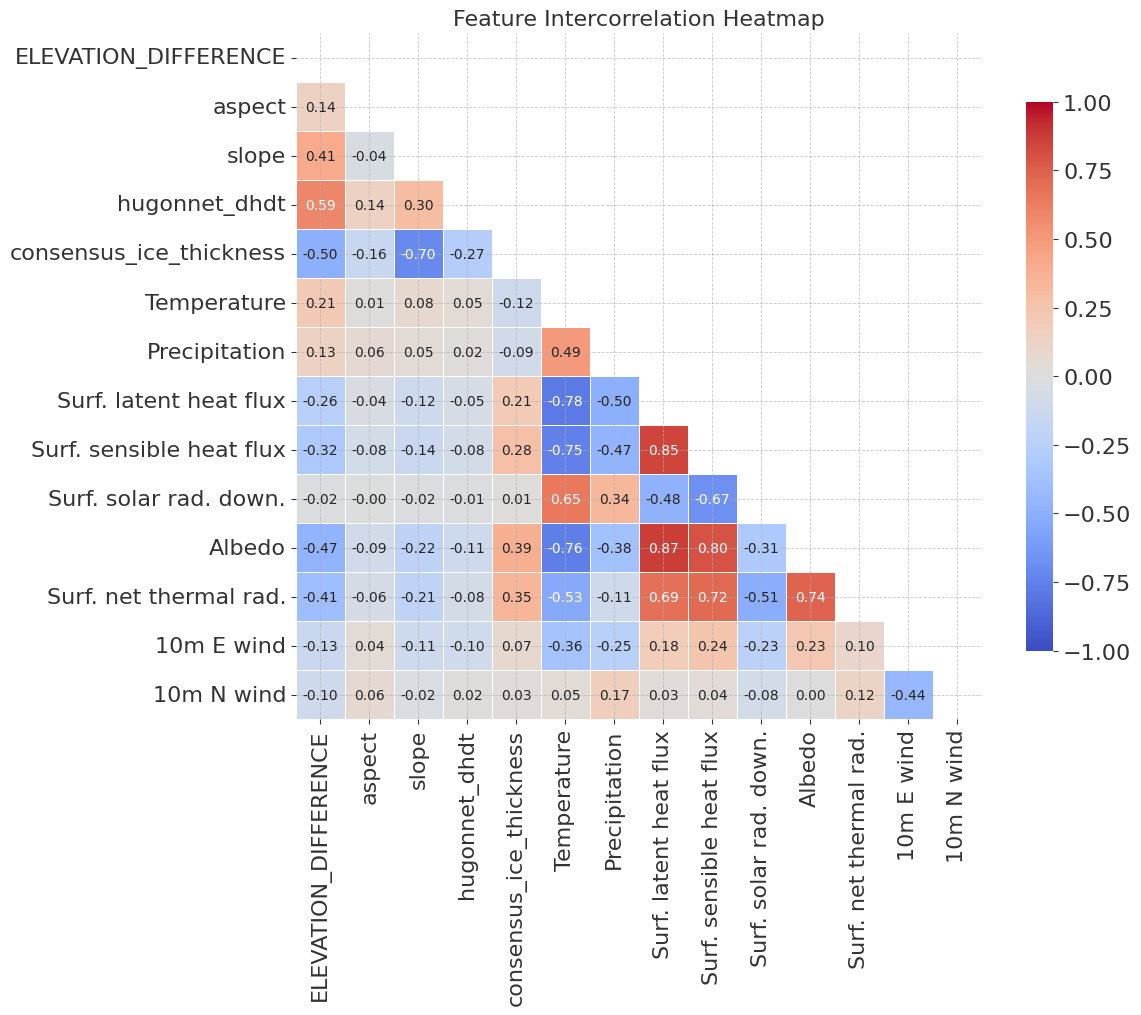

In [8]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'GLWD_ID', 'N_MONTHS', 'MONTHS'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

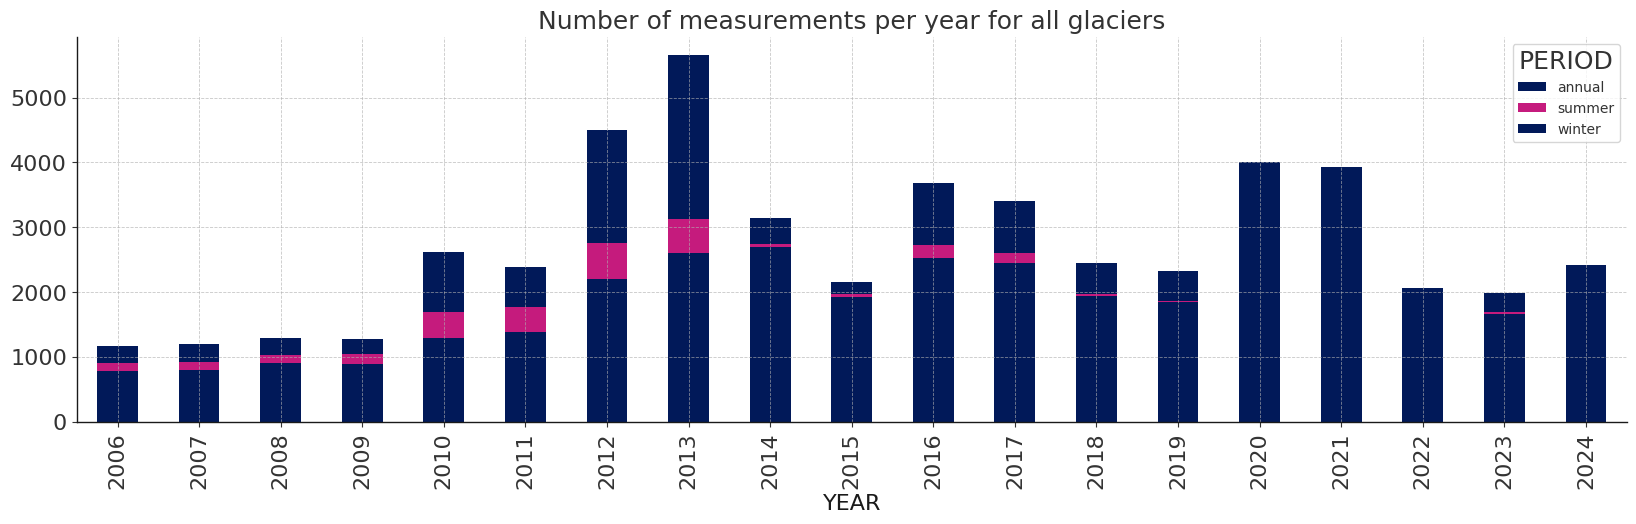

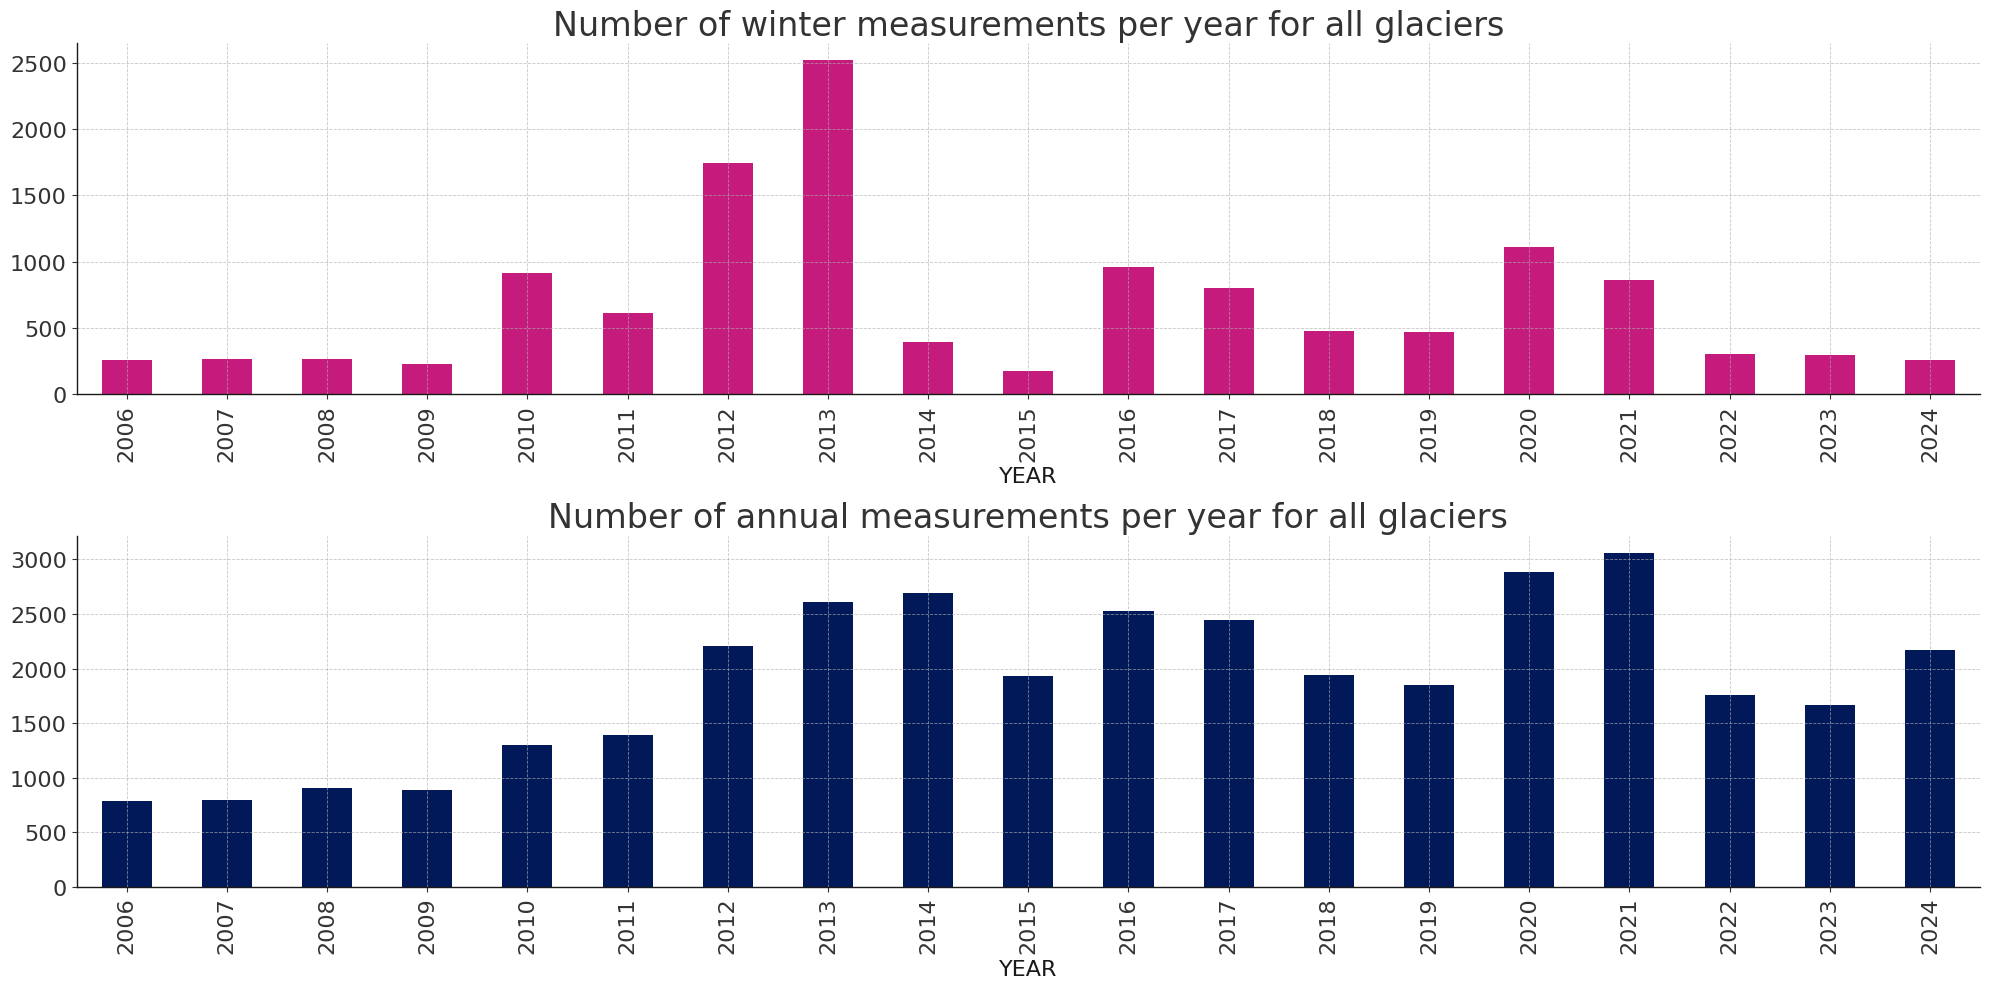

In [10]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

### Glaciers with pot. radiadation data:

In [ ]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = np.sort([
    re.search(r'xr_direct_(.*?)\.zarr', f).group(1)
    for f in os.listdir(path_pcsr + 'zarr/')
])

restgl = np.sort(Diff(list(glDirect), list(data_glamos.GLACIER.unique())))

print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Number of glaciers:', len(glDirect))
print('Glaciers without potential clear sky radiation data:\n', restgl)

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

# Look at the data of the ERA5 dataset:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

In [ ]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos['GLACIER'].apply(lambda x: glacierCap[x])

mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')
plt.tight_layout()

## Input data:
### Input dataset:

In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLAMOS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc',
    'radiation_save_path': path_pcsr + 'zarr/'
}
RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     data_glamos=data_glamos,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

### Correction for elevation difference:

In [ ]:
# Load and preprocess GloGEM factors
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors.rename(columns={'ID': 'RGIId'}, inplace=True)
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))
print(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")

# Correct t2m and tp for elevation
dataloader_gl.correct_for_elevation()

# Plot the distribution of corrected and uncorrected precipitation and temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precipitation
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=axes[0])
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=axes[0])
axes[0].set_title('Distribution of Precipitation')
axes[0].set_xlabel('Precipitation (tp / tp_corr)')
axes[0].legend()

# Temperature
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=axes[1])
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=axes[1])
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temperature (t2m / t2m_corr)')
axes[1].legend()

plt.tight_layout()
plt.show()

### Feature correlation:

In [ ]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'GLWD_ID', 'N_MONTHS', 'MONTHS'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

### Num. meas per year:

In [ ]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

### Sanity checks:

In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate + ['pcsr']
df = df[(df.GLACIER == 'corvatsch') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

In [ ]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

## Blocking on glaciers:

In [ ]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'corvatsch', 'tsanfleuron', 'forno'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

#### Heatmap annual:

In [ ]:
data_glamos.GLACIER.unique()

In [ ]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='annual')

#### Heatmap winter:

In [ ]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='winter')

#### CV splits:

In [ ]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

In [ ]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate + ['pcsr']):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

In [ ]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

In [ ]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [ ]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

### Grid search:

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_gl_split_sgi_corr.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_gl_split_sgi_corr.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
# feature_columns = ['ELEVATION_DIFFERENCE'
#                    ] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
geodetic_mb = get_geodetic_MB()

# filter to glaciers with potential clear sky radiation data
geodetic_mb = geodetic_mb[geodetic_mb.glacier_name.isin(glDirect)]

# get years per glacier
years_start_per_gl = geodetic_mb.groupby(
    'glacier_name')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodetic_mb.groupby('glacier_name')['Aend'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)

# Iterate through the DataFrame rows
for _, row in geodetic_mb.iterrows():
    glacier_name = row['glacier_name']
    start_year = row['Astart']
    end_year = row['Aend']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    # Only if period is longer than 5 years
    if end_year - start_year >= 5:
        periods_per_glacier[glacier_name].append((start_year, end_year))
        geoMB_per_glacier[glacier_name].append(geoMB)

# sort by glacier_list
periods_per_glacier = dict(sorted(periods_per_glacier.items()))
geoMB_per_glacier = dict(sorted(geoMB_per_glacier.items()))

### Glacier wide MB: 
Compute 2D fields.

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?).zarr', f).group(1)
    for f in os.listdir(path_pcsr + 'zarr/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

# satellite_glaciers = [
#     'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
#     'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
#     'schwarzbach', 'schwarzberg'
# ]

geodetic_glaciers = periods_per_glacier.keys()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

#### GLAMOS grids & Normal T & P:

In [ ]:
RUN = False
if RUN:
    # Define paths
    path_save_glw = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/distributed_MB_grids/MBM/glamos_dems/'
    path_xr_grids = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    # feature_columns = ['ELEVATION_DIFFERENCE'
    #                    ] + list(vois_climate) + list(vois_topographical)
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical) + ['pcsr']
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        glacier_files = sort_by_area(glacier_files, gl_area)

        for file_name in tqdm(glacier_files,
                              desc=f"Processing {glacier_name}",
                              leave=False):
            year = int(file_name.split('_')[2].split('.')[0])

            # Load parquet input glacier grid file in monthly format (pre-processed)
            df_grid_monthly = pd.read_parquet(
                os.path.join(path_glacier_grid_glamos, glacier_name,
                             file_name))
            df_grid_monthly.drop_duplicates(inplace=True)

            # Keep only necessary columns, avoiding missing columns issues
            df_grid_monthly = df_grid_monthly[[
                col for col in all_columns if col in df_grid_monthly.columns
            ]]

            # Add GLWD_ID
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly.apply(
            #     lambda x: get_hash(f"{x.GLACIER}_{x.YEAR}"), axis=1)
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly['GLWD_ID'].astype(str)

            # Create geodata object
            geoData = mbm.GeoData(df_grid_monthly)

            # Computes and saves gridded MB for a year and glacier
            path_glacier_dem = os.path.join(path_xr_grids,
                                            f"{glacier_name}_{year}.zarr")
            geoData.gridded_MB_pred(custom_model,
                                    glacier_name,
                                    year,
                                    all_columns,
                                    path_glacier_dem,
                                    path_save_glw,
                                    cfg,
                                    save_monthly_pred=True)

In [ ]:
glacier_name = 'clariden'
year = 2010
# open xarray
xr.open_dataset(
    path_save_glw +
    f'{glacier_name}/{glacier_name}_{year}_annual.zarr').pred_masked.plot()